In [1]:
import torch
import torch.nn as nn
import numpy as np
from nbodykit.lab import *
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import yt

def standard_plot(w=10,h=4,fontsize=14):
    fig = plt.figure(figsize=(w,h))
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'font.size': fontsize})
    plt.rcParams['font.family'] = 'DejaVu Sans'
    #plt.rc('text', usetex=True)
    return plt.gca()

def density(x_in,y_in,z_in,boxsize,Ngrid):
    
    cell_len=np.float(boxsize)/np.float(Ngrid)
    print('cell_len = ',cell_len)
    
    x_dat=x_in/cell_len
    y_dat=y_in/cell_len
    z_dat=z_in/cell_len

    #Create a new grid which will contain the densities
    grid = np.zeros([Ngrid, Ngrid, Ngrid], dtype='float64')
    
    #Find cell center coordinates
    x_c = np.floor(x_dat).astype(int)
    y_c = np.floor(y_dat).astype(int)
    z_c = np.floor(z_dat).astype(int)
    
    #Calculating contributions for the CIC interpolation
    d_x = x_dat - x_c
    d_y = y_dat - y_c
    d_z = z_dat - z_c
    
    t_x = 1. - d_x
    t_y = 1. - d_y
    t_z = 1. - d_z
    
    #Enforce periodicity for cell center coordinates + 1                
    X = (x_c+1)%Ngrid
    Y = (y_c+1)%Ngrid
    Z = (z_c+1)%Ngrid
    
    #Populate the density grid according to the CIC scheme
    
    aux, edges = np.histogramdd(np.array([z_c,y_c,x_c]).T, weights=t_x*t_y*t_z, bins=(Ngrid,Ngrid,Ngrid), range=[[0,Ngrid],[0,Ngrid],[0,Ngrid]])
    grid += aux
   
    aux, edges = np.histogramdd(np.array([z_c,y_c,X]).T, weights=d_x*t_y*t_z, bins=(Ngrid,Ngrid,Ngrid), range=[[0,Ngrid],[0,Ngrid],[0,Ngrid]])
    grid += aux
    
    aux, edges = np.histogramdd(np.array([z_c,Y,x_c]).T, weights=t_x*d_y*t_z, bins=(Ngrid,Ngrid,Ngrid), range=[[0,Ngrid],[0,Ngrid],[0,Ngrid]])
    grid += aux
    
    aux, edges = np.histogramdd(np.array([Z,y_c,x_c]).T, weights=t_x*t_y*d_z, bins=(Ngrid,Ngrid,Ngrid), range=[[0,Ngrid],[0,Ngrid],[0,Ngrid]])
    grid += aux
    
    aux, edges = np.histogramdd(np.array([z_c,Y,X]).T, weights=d_x*d_y*t_z, bins=(Ngrid,Ngrid,Ngrid), range=[[0,Ngrid],[0,Ngrid],[0,Ngrid]])
    grid += aux
    
    aux, edges = np.histogramdd(np.array([Z,Y,x_c]).T, weights=t_x*d_y*d_z, bins=(Ngrid,Ngrid,Ngrid), range=[[0,Ngrid],[0,Ngrid],[0,Ngrid]])
    grid += aux
    
    aux, edges = np.histogramdd(np.array([Z,y_c,X]).T, weights=d_x*t_y*d_z, bins=(Ngrid,Ngrid,Ngrid), range=[[0,Ngrid],[0,Ngrid],[0,Ngrid]])
    grid += aux
    
    aux, edges = np.histogramdd(np.array([Z,Y,X]).T, weights=d_x*d_y*d_z, bins=(Ngrid,Ngrid,Ngrid), range=[[0,Ngrid],[0,Ngrid],[0,Ngrid]])
    grid += aux
    
    return grid



In [2]:
fname = '/cfs/home/ludo4644/ML4BORG/ICs/N128L250_11052022_May/resim/snap_borg_025.hdf5'
#fname = '/cfs/home/ludo4644/ML4BORG/ICs/N128L250_11052022_May/resim/snap_borg_001.hdf5'

unit_base = {'UnitLength_in_cm'         : 3.085678e24,
             'UnitMass_in_g'            :   1.989e+43,
             'UnitVelocity_in_cm_per_s' :      1e5}

bbox_lim = 250//2 #mpc/h

bbox = [[-bbox_lim,bbox_lim],
        [-bbox_lim,bbox_lim],
        [-bbox_lim,bbox_lim]]
 
ds = yt.load(fname,unit_base=unit_base) #,bounding_box=bbox)
ds.index
ad = ds.all_data()

yt : [INFO     ] 2022-05-12 09:27:06,280 Calculating time from 1.000e+00 to be 4.193e+17 seconds
yt : [INFO     ] 2022-05-12 09:27:06,358 Parameters: current_time              = 4.192541928807908e+17 s
yt : [INFO     ] 2022-05-12 09:27:06,359 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2022-05-12 09:27:06,359 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-05-12 09:27:06,360 Parameters: domain_right_edge         = [250. 250. 250.]
yt : [INFO     ] 2022-05-12 09:27:06,360 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-05-12 09:27:06,360 Parameters: current_redshift          = -4.440892098500626e-16
yt : [INFO     ] 2022-05-12 09:27:06,361 Parameters: omega_lambda              = 0.693
yt : [INFO     ] 2022-05-12 09:27:06,361 Parameters: omega_matter              = 0.307
yt : [INFO     ] 2022-05-12 09:27:06,361 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2022-05-12 09:27:06,362 Parameters: hubble_constant     

In [3]:
arg_ind = np.argsort(np.array(ad["ParticleIDs"]))
coordinates = ad["nbody","Coordinates"] 

#ids = np.array(ad["ParticleIDs"])[arg_ind]
coordinates = coordinates[arg_ind]

/cfs/home/ludo4644/.local-co/envs/BORG/lib/python3.7/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'ParticleIDs' is ambiguous and corresponds to any one of the following field types:
 {'all', 'nbody'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("all", "ParticleIDs")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)


In [4]:
xco = np.array([x[0] for x in coordinates])
yco = np.array([x[1] for x in coordinates])
zco = np.array([x[2] for x in coordinates])
for i in range(0,20):
    print(xco[i],yco[i],zco[i])

247.35093688964844 247.8011016845703 248.10353088378906
246.84149169921875 249.28494262695312 249.72703552246094
246.47640991210938 249.8846435546875 249.47531127929688
246.5250701904297 0.031144531443715096 249.74588012695312
246.17294311523438 0.45071300864219666 0.20779845118522644
246.42576599121094 0.9905116558074951 3.3584346771240234
249.0584259033203 0.627410888671875 5.255846977233887
2.111407518386841 0.5006154179573059 7.332041263580322
5.106191158294678 2.249385118484497 10.791580200195312
6.571559906005859 1.0282262563705444 11.951776504516602
7.030053615570068 1.744615912437439 11.19095516204834
8.326484680175781 246.12167358398438 18.48737144470215
10.528365135192871 240.6157989501953 24.93561553955078
10.729225158691406 240.70535278320312 24.88011932373047
10.384568214416504 240.76785278320312 25.07042121887207
10.591211318969727 241.14906311035156 26.22416877746582
10.349410057067871 241.21998596191406 25.9435977935791
11.06242847442627 241.65406799316406 23.5679702758

In [5]:
np.array(coordinates)

array([[247.35093689, 247.80110168, 248.10353088],
       [246.8414917 , 249.28494263, 249.72703552],
       [246.47640991, 249.88464355, 249.47531128],
       ...,
       [248.10009766, 245.54455566, 246.4874115 ],
       [247.33955383, 246.33247375, 246.31156921],
       [249.77519226, 245.25601196, 248.46763611]])

In [76]:
new_dens = density(zco, yco, xco, 250, 256)
new_dens_low = density(zco, yco, xco, 250, 64)

/cfs/home/ludo4644/.local-co/envs/BORG/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


cell_len =  0.9765625
cell_len =  3.90625


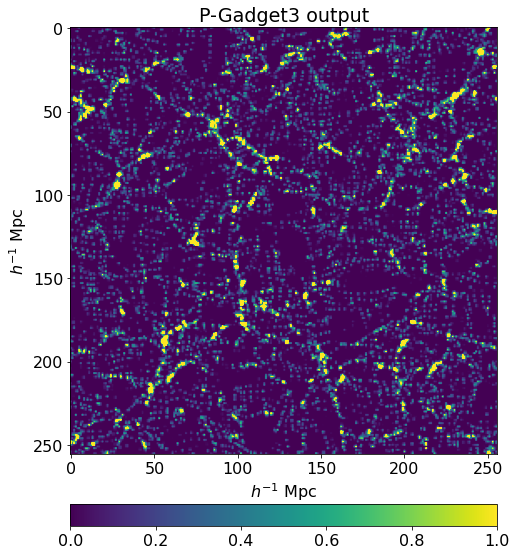

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 16})
nslice = 3
im = plt.imshow(np.sum(new_dens[:,:,32:33],axis=-1),vmax=1)
ax = plt.gca()
ax.set_xlabel('$h^{-1}$ Mpc')
ax.set_ylabel('$h^{-1}$ Mpc')
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im, cax=cax, orientation="horizontal")
ax.set_title('P-Gadget3 output')
plt.tight_layout()
plt.show()

In [9]:
ds = yt.load("/cfs/home/ludo4644/ML4BORG/ICs/borg_resim_at_sol-login.fysik.su.se_11052022_May/ic/ic.gad")

yt : [INFO     ] 2022-05-11 18:13:51,599 Calculating time from 1.429e-02 to be 8.992e+14 seconds
yt : [INFO     ] 2022-05-11 18:13:51,600 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2022-05-11 18:13:51,670 Parameters: current_time              = 899194165277962.4 s
yt : [INFO     ] 2022-05-11 18:13:51,670 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2022-05-11 18:13:51,671 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-05-11 18:13:51,671 Parameters: domain_right_edge         = [250. 250. 250.]
yt : [INFO     ] 2022-05-11 18:13:51,672 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-05-11 18:13:51,672 Parameters: current_redshift          = 69.0
yt : [INFO     ] 2022-05-11 18:13:51,673 Parameters: omega_lambda              = 0.693
yt : [INFO     ] 2022-05-11 18:13:51,673 Parameters: omega_matter              = 0.307
yt : [INFO     ] 2022-05-11 18:13:51,673 Parameters: omega_radiation           = 0.0
yt : [IN

### BORG

In [8]:
#
import borg
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
import yt
import numpy as np

Initializing console.
[INFO   ] libLSS version 4937f8d11f4a7cf4e7989c6ad37d145e62d7adaf built-in modules 
[INFO S ] Registered forward models:
[INFO S ]    2LPT_CIC, 2LPT_CIC_OPENMP, 2LPT_DOUBLE, 2LPT_NGP, ALTAIR_AP, Downgrade
[INFO S ]    EnforceMass, HADES_LOG, HADES_PT, Haar, LPT_CIC, LPT_CIC_OPENMP, LPT_DOUBLE
[INFO S ]    LPT_NGP, LPT_NU_CIC, LPT_NU_CIC_OPENMP, PATCH_MODEL, PM_CIC, PM_CIC_OPENMP
[INFO S ]    PM_CIC_OPENMP2, PRIMORDIAL, PRIMORDIAL_AS, PRIMORDIAL_FNL, QLPT, QLPT_RSD
[INFO S ]    Softplus, TRANSFER_CLASS, TRANSFER_EHU, Transfer, Upgrade, bias::BrokenPowerLaw
[INFO S ]    bias::DoubleBrokenPowerLaw, bias::EFT, bias::EFT_Thresh, bias::Linear
[INFO S ]    bias::ManyPower_1^1, bias::ManyPower_1^2, bias::ManyPower_1^4, bias::ManyPower_2^2
[INFO S ]    bias::Noop, bias::PowerLaw
[INFO S ] Registered forward models (v3):
[INFO S ]    SphereProjection
[INFO S ] Registered likelihoods:
[INFO S ]    BORG_NULL, BORG_POISSON, BORG_REDUCED_SHEAR, BORG_SHEAR, BORG_STUDENT_T
[INFO 

In [9]:
global step_id
chain = 0 

# setup the box
bb = borg.forward.BoxModel()

L = 250
Nt = 128

bb.L = L,L,L
bb.N = Nt,Nt,Nt

# Initialize some default cosmology
cosmo = borg.cosmo.CosmologicalParameters()

# Fiducial scale factor to express initial conditions
z_start = 69
a0 = 0.001
nsteps = 20

chain = borg.forward.ChainForwardModel(bb)
# Add primordial fluctuations
chain.addModel(borg.forward.models.Primordial(bb, a0))
# Add E&Hu transfer function
chain.addModel(borg.forward.models.EisensteinHu(bb))
# Run an LPT model from a=0.0 to af. The ai=a0 is the scale factor at which the IC are expressed
#lpt = borg.forward.models.BorgLpt(bb, bb, ai=a0, af=1.0)
lpt = borg.forward.models.BorgPM(bb, bb, ai=a0, af=1.0, z_start=z_start, particle_factor=1, force_factor=2, supersampling=1, nsteps=nsteps, tCOLA = 1)
chain.addModel(lpt)

pos_array = np.zeros((nsteps,Nt**3,3))
step_id=0
def notif(t, Np, ids, poss, vels):
    global step_id
    print(f"Step {t} / {step_id}  (Np={Np})")
    pos_array[step_id,:,:] = poss
    step_id+=1

lpt.setStepNotifier(notif, with_particles=True)

# Set the cosmology
chain.setCosmoParams(cosmo)

# Generate white noise: it has to be scaled by 1/N**(3./2) to be one in Fourier
np.random.seed(42)
s_field = np.random.normal(0,1,(Nt,Nt,Nt))
ic = np.fft.rfftn(s_field/np.sqrt(Nt**3))
print('np.std(ic) = ',np.std(ic))
#ic = np.fft.rfftn(np.random.randn(Ng, Ng, Ng)/np.sqrt(Ng**3))
delta_m = np.zeros((Nt,Nt,Nt))

# RUN!
chain.forwardModel_v2(ic)
chain.getDensityFinal(delta_m)

# Get pos
pos = np.zeros((lpt.getNumberOfParticles(),3))
lpt.getParticlePositions(pos)


[INFO S ] Entering [/build/jenkins/miniconda3/envs/builder/conda-bld/aquila_borg_1645958964257/work/libLSS/physics/forwards/pm/steps/types.hpp]void LibLSS::PM::init_mgr(std::shared_ptr<LibLSS::MPI_Communication>, LibLSS::PM::PMGrid&, bool)
[INFO S ] | Allocating grid 128x128x128 (transposed=0)
[INFO S ] Done
[INFO S ] Entering [/build/jenkins/miniconda3/envs/builder/conda-bld/aquila_borg_1645958964257/work/libLSS/physics/forwards/pm/steps/types.hpp]void LibLSS::PM::init_mgr(std::shared_ptr<LibLSS::MPI_Communication>, LibLSS::PM::PMGrid&, bool)
[INFO S ] | Allocating grid 128x128x128 (transposed=0)
[INFO S ] Done
[INFO S ] Entering [/build/jenkins/miniconda3/envs/builder/conda-bld/aquila_borg_1645958964257/work/libLSS/physics/forwards/pm/steps/types.hpp]void LibLSS::PM::init_mgr(std::shared_ptr<LibLSS::MPI_Communication>, LibLSS::PM::PMGrid&, bool)
[INFO S ] | Allocating grid 256x256x256 (transposed=1)
[INFO S ] Done
[INFO S ] | | |  [step] an0=0.0402256 an1=0.0921053 anh0=0.0142857 anh

In [11]:
pos_array[0]

array([[249.87370121, 249.82134519, 249.63995199],
       [249.89500311, 249.67379414,   1.62390187],
       [249.93528449, 249.49110083,   3.7929122 ],
       ...,
       [248.1155276 , 248.01199481, 244.00010089],
       [248.16349188, 247.94271759, 245.52843434],
       [248.23229042, 247.74400183, 247.87708392]])

In [69]:
BORG_final_dens = density(pos[:,0],pos[:,1],pos[:,2],L,256)
BORG_final_dens_low = density(pos[:,0],pos[:,1],pos[:,2],L,64)

/cfs/home/ludo4644/.local-co/envs/BORG/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


cell_len =  0.9765625
cell_len =  3.90625


In [13]:
BORG_final_dens

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.99057847e-01, ...,
         0.00000000e+00, 1.02219720e-01, 6.93542249e-02],
        [0.00000000e+00, 0.00000000e+00, 3.10541756e-01, ...,
         0.00000000e+00, 7.36700939e-02, 4.99838219e-02],
        ...,
        [2.69709136e+00, 1.02231118e-01, 0.00000000e+00, ...,
         0.00000000e+00, 5.62228762e-01, 3.85978407e+00],
        [4.52476485e-01, 1.24750939e-01, 4.24888624e-01, ...,
         0.00000000e+00, 0.00000000e+00, 4.33634274e-02],
        [4.85488443e-03, 6.17725531e-03, 2.12929733e-01, ...,
         0.00000000e+00, 0.00000000e+00, 1.29076852e-04]],

       [[1.24963368e-02, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.19135679e-01],
        [0.00000000e+00, 0.00000000e+00, 2.20881415e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 

In [14]:
def plot_dens(dens,t,vmax=1,axis_to_show=0,nslice_min=0,nslice_max=-1):
    fig = plt.gcf()
    if axis_to_show==0:
        dens_to_plot = dens[nslice_min:nslice_max,:,:]
    elif axis_to_show==1:
        dens_to_plot = dens[:,nslice_min:nslice_max,:]
    else:
        dens_to_plot = dens[:,:,nslice_min:nslice_max]
    
    im = plt.imshow(np.sum(dens_to_plot,axis=axis_to_show),vmax=vmax,origin='lower')
    ax = plt.gca()    
    ax.set_xlabel('$h^{-1}$ Mpc')
    ax.set_ylabel('$h^{-1}$ Mpc')
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
    fig.add_axes(cax)
    fig.colorbar(im, cax=cax, orientation="horizontal")
    ax.set_title(t)

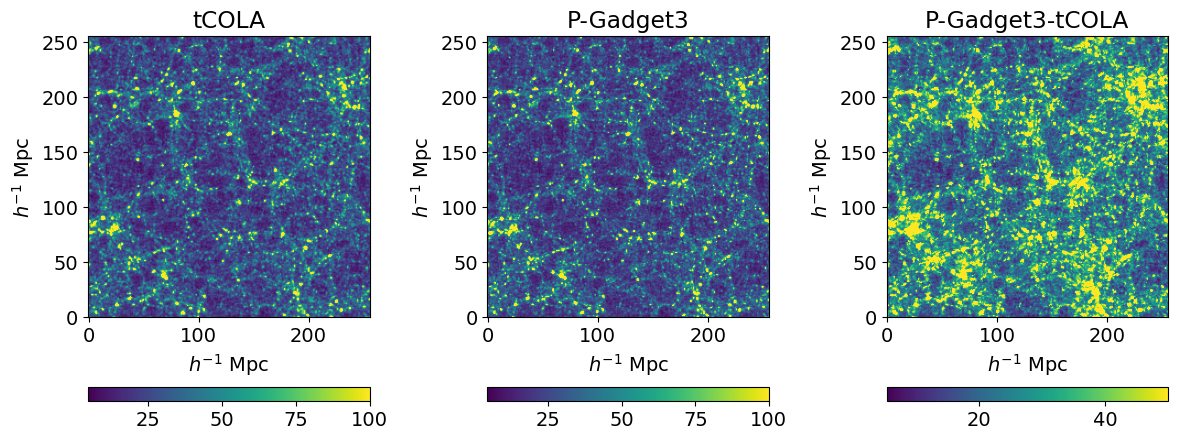

In [20]:
axis_to_show = 1

standard_plot(w=12,h=8)
plt.subplot(1,3,1)
plot_dens(BORG_final_dens,'tCOLA',axis_to_show=axis_to_show,vmax=100)
plt.subplot(1,3,2)
plot_dens(new_dens,'P-Gadget3',axis_to_show=axis_to_show,vmax=100)
plt.subplot(1,3,3)
plot_dens(np.abs(BORG_final_dens-new_dens),'P-Gadget3-tCOLA',axis_to_show=axis_to_show,vmax=50)
plt.tight_layout()
plt.show()

### Compare power spectra

In [63]:
import sys
sys.path.append('../ML_into_BORG/src')
from pk import getPk

In [59]:
abs_pos_GADGET = coordinates
abs_pos_COLA = pos 

In [77]:
k,Pk = getPk(BORG_final_dens)
k2,Pk2 = getPk(new_dens)

klow,Pklow = getPk(BORG_final_dens_low)
klow2,Pklow2 = getPk(new_dens_low)

../ML_into_BORG/src/pk.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  dk2=(deltak*np.conjugate(deltak)).astype(np.float)


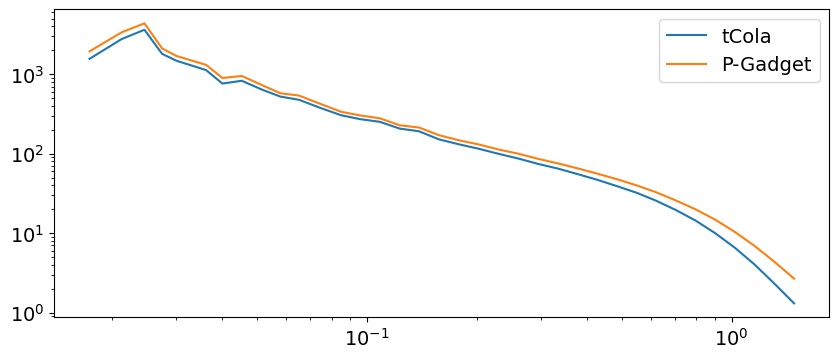

In [80]:
standard_plot()
plt.loglog(k,Pk,label='tCola')
plt.loglog(k2,Pk2,label='P-Gadget')
#plt.loglog(klow,Pklow,label='tCola low')
#plt.loglog(klow2,Pklow2,label='P-Gadget low')
plt.legend()
plt.show()

In [58]:
mesh_GADGET = ArrayMesh(abs_pos_GADGET, BoxSize=L, window='tsc',Nmesh=128)
mesh_COLA   = ArrayMesh(abs_pos_COLA  , BoxSize=L, window='tsc')

AssertionError: 

In [56]:
# compute the power, specifying desired linear k-binning
r = FFTPower(mesh_GADGET, mode='1d', dk=0.005, kmin=0.01)

KeyboardInterrupt: 

In [48]:
# the result is stored at "power" attribute
Pk = r.power
print(Pk)

<BinnedStatistic: dims: (k: 6), variables: ('k', 'power', 'modes')>


In [54]:
# print out the meta-data
for k in Pk.attrs:
    print("%s = %s" %(k, str(Pk.attrs[k])))

Nmesh = [10000     3]
BoxSize = [250. 250.]
Lx = 250.0
Ly = 250.0
volume = 62500.0
mode = 1d
los = [0, 0, 1]
Nmu = 1
poles = []
dk = 0.005
kmin = 0.01
kmax = None
N1 = 0
N2 = 0
shotnoise = 0


Text(0, 0.5, '$P(k)$ [$h^{-3}\\mathrm{Mpc}^3$]')

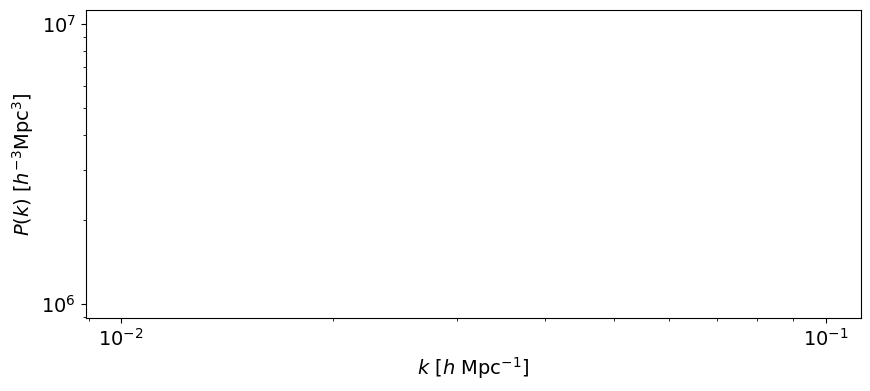

In [49]:
standard_plot()
# print the shot noise subtracted P(k)
plt.loglog(Pk['k'], Pk['power'].real - Pk.attrs['shotnoise'])

# format the axes
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
#plt.xlim(0.01, 0.6)

### Disp

In [81]:
def pre_process(abs_pos,L,Ng,order='F'):
    
    # Memory layout of multi-dimensional arrays (row vs column major)
    psi = np.zeros(np.shape(abs_pos))
    x_q_v = np.zeros(np.shape(abs_pos))
    dx = L/Ng

    for i in range(0,Ng):
        for j in range(0,Ng):
            for k in range(0,Ng):
                if order=='F':
                    n = k + Ng*(j + Ng*i) #column
                elif order=='C':
                    n = i + Ng*(j + Ng*k) #row

                qx = i*dx
                qy = j*dx
                qz = k*dx

                x_q_v[n] = [qx,qy,qz]

                psi[n] = abs_pos[n] - [qx,qy,qz]
    
    return x_q_v, psi

In [82]:
gad_pos = np.array(coordinates)
#gad_pos = np.reshape(np.array([gad_pos[:,2],gad_pos[:,1],gad_pos[:,0]]),(Nt**3,3))
col_pos = pos

In [83]:
x_q_v_gad, disp_gad = pre_process(gad_pos,L,Nt,order='F')

In [84]:
x_q_v_gad

array([[  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   1.953125],
       [  0.      ,   0.      ,   3.90625 ],
       ...,
       [248.046875, 248.046875, 244.140625],
       [248.046875, 248.046875, 246.09375 ],
       [248.046875, 248.046875, 248.046875]])

In [85]:
x_q_v_col, disp_col = pre_process(col_pos,L,Nt,order='F')

In [86]:
x_q_v_col

array([[  0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   1.953125],
       [  0.      ,   0.      ,   3.90625 ],
       ...,
       [248.046875, 248.046875, 244.140625],
       [248.046875, 248.046875, 246.09375 ],
       [248.046875, 248.046875, 248.046875]])

In [87]:
DPF_COLA = np.reshape(disp_col,(Nt,Nt,Nt,3),order='F')
DPF_GADGET = np.reshape(disp_gad,(Nt,Nt,Nt,3),order='F')

In [88]:
DPF_COLA[:2,:2,:2,:]

array([[[[248.65199694, 248.2758025 , 247.35806092],
         [247.99745634, 249.18192504, 246.80946768]],

        [[249.29676713,   1.16667927, 243.79140755],
         [ -1.32663073,   2.5671057 , 242.42955657]]],


       [[[248.98053987, 245.84707062,  -1.75127493],
         [247.12413268, 246.09648687, 247.99847812]],

        [[249.66400579,  -1.89879271, 244.67789208],
         [ -1.66776203,  -0.27469685, 243.37081647]]]])

In [89]:
DPF_GADGET[:2,:2,:2,:]

array([[[[ 2.47350937e+02,  2.47801102e+02,  2.48103531e+02],
         [ 2.47233383e+02,  2.44668808e+02,  2.49551773e+02]],

        [[ 2.43082092e+02,  6.79383039e-01,  2.49013260e+02],
         [ 2.44504089e+02,  2.47807648e+02,  7.73854032e-02]]],


       [[[ 2.46841492e+02,  2.49284943e+02,  2.47773911e+02],
         [ 2.47444962e+02,  2.45883972e+02,  2.46797577e+02]],

        [[ 2.41231583e+02,  1.74415207e+00,  2.48032974e+02],
         [ 2.44142578e+02, -1.57071486e+00,  2.47955917e+02]]]])

In [90]:
diff = DPF_GADGET-DPF_COLA
diff = diff

diff = np.linalg.norm(DPF_GADGET-DPF_COLA,axis=-1)
diff = np.reshape(diff,Nt**3) % L
print(diff.shape)

(2097152,)


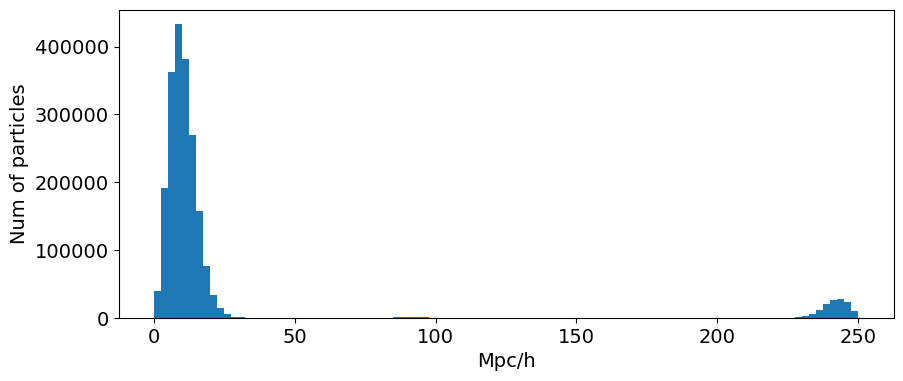

In [91]:
standard_plot()
plt.hist(diff,bins=100)
plt.xlabel('Mpc/h')
plt.ylabel('Num of particles')
plt.show()

### Save data

In [92]:
outfile = 'Pgadget3_and_tCOLA'

np.savez(outfile, 
         abs_pos_GADGET=abs_pos_GADGET, 
         abs_pos_COLA=abs_pos_COLA, 
         DPF_GADGET=DPF_GADGET,
         DPF_COLA=DPF_COLA,
        )

# First run ML

In [28]:
%matplotlib inline 
%config InlineBackend.figure_format='retina'
%pylab inline

import h5py
import numpy as np
import pandas as pd
import struct

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, Model, Input
from tensorflow.keras.layers import*
import tensorflow.keras as keras

from nbodykit.lab import *
from nbodykit import setup_logging, style
from nbodykit.lab import ArrayMesh

Populating the interactive namespace from numpy and matplotlib


/cfs/home/ludo4644/.local-co/envs/BORG/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['diff']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Dataloder

## Data Preparation 

In [29]:
###need to modify this for the training set
def random_select(DPF_COLA,DPF_GADGET,size=50): #for momentum
    #augmentation and such 
    """
    This function randomly select a subbox from a full volume simulation 
    return a cropped Displacement field with a size^3 volume
    """
    #random the rollling coordinate
    rnd=np.random.uniform(0,128-size,size=3).astype(int)
    DPF_COLA_cropped   = DPF_COLA  [rnd[0]:rnd[0]+size,rnd[1]:rnd[1]+size,rnd[2]:rnd[2]+size,:]
    DPF_GADGET_cropped = DPF_GADGET[rnd[0]:rnd[0]+size,rnd[1]:rnd[1]+size,rnd[2]:rnd[2]+size,:]
    
    return DPF_COLA_cropped , DPF_GADGET_cropped

def generator():
    """
    This function apply the data random_select (can be modified) 
    and batched the dataset on the fily
    """
    
    na=np.newaxis
    for i in range (128):

        # DPF_COLA,DPF_GADGET = padding(DPF_COLA,DPF_GADGET)
        
        DPF_COLA_cropped , DPF_GADGET_cropped = random_select(DPF_COLA,DPF_GADGET,size=32) #
        #yield (DM_cropped[:,:,:,na],fields_cropped)
        yield (DPF_COLA_cropped , DPF_GADGET_cropped)
        
dataset = tf.data.Dataset.from_generator(generator, (tf.float32, tf.float32))
dataset = dataset.cache().batch(64)
width, height, depth = 32, 32, 32

In [30]:
#sanity check
for i in dataset:
    print(i[0].shape)
    print(i[1].shape)

(64, 32, 32, 32, 3)
(64, 32, 32, 32, 3)
(64, 32, 32, 32, 3)
(64, 32, 32, 32, 3)


# Architecture

## U-net 3D

In [31]:
#this one bottleneck down to 8^3
def U_net_3d_1(width, height, depth,lr=0.001,input_ch=1):
    tf.keras.backend.clear_session()
    width, height, depth = 32, 32, 32
    
    in1 = keras.Input((width, height, depth, input_ch))

    conv1 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(in1)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling3D((2, 2, 2))(conv1)

    conv2 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling3D((2, 2, 2))(conv2)

    conv3 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(conv3)

    ########################################################
    up1 = concatenate([UpSampling3D((2, 2, 2))(conv3), conv2], axis=-1)
    conv4 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(up1)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

    up2 = concatenate([UpSampling3D((2, 2, 2))(conv4), conv1], axis=-1)
    conv6 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    ########################################################

    model = Model(inputs=[in1], outputs=[conv6],name='U-net3D')
    model.summary()
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [68]:
#this one bottleneck down to 4^3
def U_net_3d_2(width, height, depth,lr=0.001,input_ch=1):
    tf.keras.backend.clear_session()

    input_ch = 3
    in1 = keras.Input((width, height, depth, input_ch))

    conv1 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(in1)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling3D((2, 2, 2))(conv1)

    conv2 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling3D((2, 2, 2))(conv2)

    conv3 = Conv3D(filters=32, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv3D(filters=32, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = MaxPooling3D((2, 2, 2))(conv3)

    conv4 = Conv3D(filters=64, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv3D(filters=64, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

    ########################################################
    up1 = concatenate([UpSampling3D((2, 2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv3D(filters=64, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(up1)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv3D(filters=64, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(conv5)

    up2 = concatenate([UpSampling3D((2, 2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv3D(filters=32, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    #conv6 = Dropout(0.2)(conv6)
    conv6 = Conv3D(filters=32, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    up3 = concatenate([UpSampling3D((2, 2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv3D(filters=16, kernel_size=(2, 2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(up3)
    #conv7 = Dropout(0.2)(conv7)
    conv7 = Conv3D(filters=16, kernel_size=(2, 2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    conv7 = Conv3D(filters=3, kernel_size=(2,2,2), kernel_initializer='he_normal', padding='same')(conv7)
    ########################################################
    
    model = Model(inputs=[in1], outputs=[conv7],name='U-net3D')
    model.summary()

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

# Training

In [69]:
%%time
#width, height, depth = 81, 81, 81
unet3d  = U_net_3d_2(width,height,depth,lr=0.01,input_ch=3)
#unet3d.load_weights('model_Unet.h5') 

run   = unet3d.fit(dataset, epochs=1000)#,batch_size=32)#,steps_per_epoch=10)

plt.semilogy(run.history['loss'],label='loss')
plt.semilogy(run.history['mean_squared_error'],label='mse')
plt.legend()

Model: "U-net3D"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 32,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 32, 32, 32,   400         ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 dropout (Dropout)              (None, 32, 32, 32,   0           ['conv3d[0][0]']                 
                                16)                                                         

__________________________________________________________________________________________________
Epoch 1/1000
2/2 [==============================] - 2s 112ms/step - loss: 2112.5964 - mean_squared_error: 2112.5964
Epoch 2/1000
2/2 [==============================] - 0s 74ms/step - loss: 149.7939 - mean_squared_error: 149.7939
Epoch 3/1000
2/2 [==============================] - 0s 71ms/step - loss: 153.7372 - mean_squared_error: 153.7372
Epoch 4/1000
2/2 [==============================] - 0s 70ms/step - loss: 149.9057 - mean_squared_error: 149.9057
Epoch 5/1000
2/2 [==============================] - 0s 71ms/step - loss: 145.5047 - mean_squared_error: 145.5047
Epoch 6/1000
2/2 [==============================] - 0s 72ms/step - loss: 143.3185 - mean_squared_error: 143.3185
Epoch 7/1000
2/2 [==============================] - 0s 73ms/step - loss: 141.3677 - mean_squared_error: 141.3677
Epoch 8/1000
2/2 [==============================] - 0s 71ms/step - loss: 138.5449 - mean_squared_error: 138

2/2 [==============================] - 0s 71ms/step - loss: 112.5652 - mean_squared_error: 112.5652
Epoch 73/1000
2/2 [==============================] - 0s 71ms/step - loss: 111.7985 - mean_squared_error: 111.7985
Epoch 74/1000
2/2 [==============================] - 0s 71ms/step - loss: 111.1562 - mean_squared_error: 111.1562
Epoch 75/1000
2/2 [==============================] - 0s 72ms/step - loss: 113.9336 - mean_squared_error: 113.9336
Epoch 76/1000
2/2 [==============================] - 0s 72ms/step - loss: 114.0887 - mean_squared_error: 114.0887
Epoch 77/1000
2/2 [==============================] - 0s 72ms/step - loss: 110.9084 - mean_squared_error: 110.9084
Epoch 78/1000
2/2 [==============================] - 0s 72ms/step - loss: 112.4397 - mean_squared_error: 112.4397
Epoch 79/1000
2/2 [==============================] - 0s 71ms/step - loss: 111.1691 - mean_squared_error: 111.1691
Epoch 80/1000
2/2 [==============================] - 0s 72ms/step - loss: 110.8043 - mean_squared_erro

2/2 [==============================] - 0s 74ms/step - loss: 97.6470 - mean_squared_error: 97.6470
Epoch 215/1000
2/2 [==============================] - 0s 71ms/step - loss: 97.4750 - mean_squared_error: 97.4750
Epoch 216/1000
2/2 [==============================] - 0s 72ms/step - loss: 98.0862 - mean_squared_error: 98.0862
Epoch 217/1000
2/2 [==============================] - 0s 73ms/step - loss: 97.4764 - mean_squared_error: 97.4764
Epoch 218/1000
2/2 [==============================] - 0s 72ms/step - loss: 97.5427 - mean_squared_error: 97.5427
Epoch 219/1000
2/2 [==============================] - 0s 71ms/step - loss: 98.1436 - mean_squared_error: 98.1436
Epoch 220/1000
2/2 [==============================] - 0s 71ms/step - loss: 97.6030 - mean_squared_error: 97.6030
Epoch 221/1000
2/2 [==============================] - 0s 69ms/step - loss: 97.0938 - mean_squared_error: 97.0938
Epoch 222/1000
2/2 [==============================] - 0s 74ms/step - loss: 97.3717 - mean_squared_error: 97.371

KeyboardInterrupt: 

In [10]:
unet3d.save_weights('model_UNET4BORG.h5') 

# Evaluation

### Merge and tile the predicted displacement field

In [63]:
def data_select(input_DPF,output_DPF,index,size=50): #for momentum

    i=index[0]
    j=index[1]
    k=index[2]
    
    input_DPF_cropped   = input_DPF  [(i*32):(i*32)+32 , (j*32):(j*32)+32 , (k*32):(k*32)+32, :]
    output_DPF_cropped  = output_DPF [(i*32):(i*32)+32 , (j*32):(j*32)+32 , (k*32):(k*32)+32, :]

    return input_DPF_cropped ,output_DPF_cropped

DPF_pred = np.zeros((32*4,32*4,32*4,3))
DPF_true = np.zeros((32*4,32*4,32*4,3))

for k in range(4):
    print(k)
    for j in range(4):
        for i in range(4):
            
            test_DPF, true_DPF = data_select(DPF_COLA,DPF_GADGET,[i,j,k],size=32)
            
            output_i = unet3d.predict(tf.expand_dims(test_DPF,axis=0))
            print(np.shape(output_i))
            
            DPF_true[(32*i):(32*i)+32,(32*j):(32*j)+32,(32*k):(32*k)+32] = true_DPF
            DPF_pred[(32*i):(32*i)+32,(32*j):(32*j)+32,(32*k):(32*k)+32] = output_i
            
#f = h5py.File('/data78/boonkong/BORG_ML/2022/sample7200/ML_prediction/predicted_DPF.h5', 'w')
#f.create_dataset("True", ((768,768,768)), dtype='f8',data=10**DPF_true) #'f8' for a double presicion
#f.create_dataset("Pred", ((768,768,768)), dtype='f8',data=10**DPF_pred) 
#f.close()

0
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
1
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
2
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
3
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 32, 32, 32, 3)
(1, 

(array([1.35000e+02, 1.67000e+02, 1.46000e+02, 1.52000e+02, 1.44000e+02,
        1.40000e+02, 1.84000e+02, 1.86000e+02, 1.72000e+02, 1.93000e+02,
        1.83000e+02, 2.23000e+02, 2.29000e+02, 2.16000e+02, 2.35000e+02,
        2.09000e+02, 2.49000e+02, 2.78000e+02, 2.72000e+02, 2.57000e+02,
        2.81000e+02, 3.25000e+02, 3.01000e+02, 2.87000e+02, 3.29000e+02,
        3.21000e+02, 3.50000e+02, 3.93000e+02, 3.96000e+02, 3.59000e+02,
        4.14000e+02, 4.14000e+02, 4.36000e+02, 4.96000e+02, 4.88000e+02,
        5.56000e+02, 6.18000e+02, 6.26000e+02, 6.73000e+02, 7.57000e+02,
        7.39000e+02, 8.45000e+02, 8.89000e+02, 1.00400e+03, 1.06900e+03,
        1.13700e+03, 1.19400e+03, 1.37200e+03, 1.43900e+03, 1.56000e+03,
        1.91000e+03, 2.08200e+03, 2.30700e+03, 2.65200e+03, 3.13000e+03,
        3.85800e+03, 4.89100e+03, 6.24400e+03, 8.25700e+03, 1.12720e+04,
        1.47500e+04, 1.97350e+04, 2.69720e+04, 3.68330e+04, 5.04740e+04,
        7.82260e+04, 3.49088e+05, 4.94761e+05, 2.80

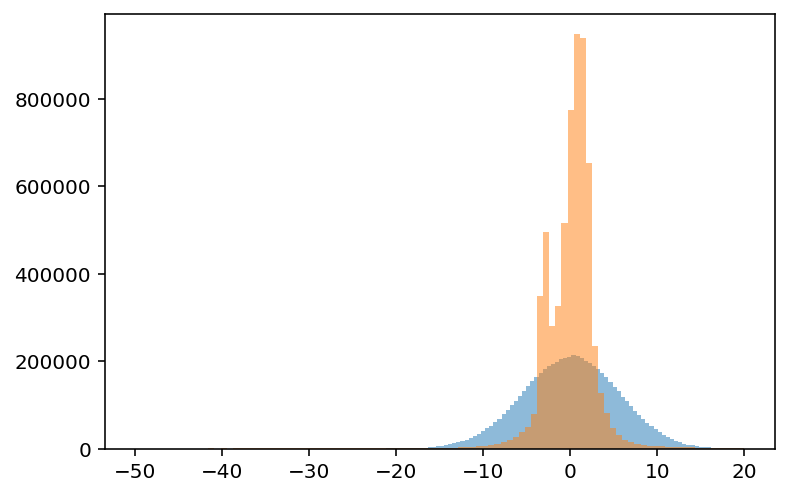

In [64]:
plt.hist(DPF_true[(DPF_true<20)&(DPF_true>-50)].flatten(),100,alpha=0.5)
plt.hist(DPF_pred  [(DPF_pred<20)&(DPF_pred>-50)].flatten(),100,alpha=0.5)

### Visual inspection for Displacement Field

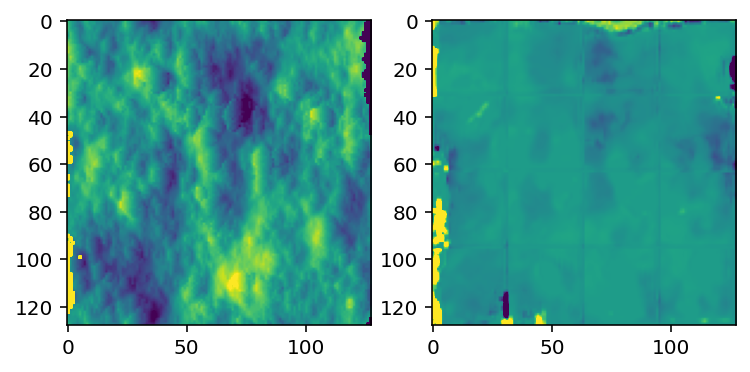

In [65]:
i = int(np.random.uniform(0,128))
plt.subplot(121)
plt.imshow(DPF_true[i][:,:,0],vmin=-15,vmax=15)
plt.subplot(122)
plt.imshow(DPF_pred[i][:,:,0],vmin=-15,vmax=15)

### Comparing the predicted density field using Power Spectra

In [47]:
#calculate the absolute position
def IC_to_snap(IC_pos,DPF): 
    return IC_pos+DPF

##############################
def dens_from_disp(disp,lagpos,L=1000,sub=True):
    pos = disp + lagpos
    pos[pos>L] -= L
    pos[pos<0] += L
    if sub:
        pos = pos[:,:128,:128,:128]
    
    return disp2dens(pos, L, N=np.shape(pos)[-1])

def disp2dens(pos, L, N, ngrid_pl=512):
    
    pos = pos.reshape(3,N**3,order='F')
    x,y,z = pos[0],pos[1],pos[2]

    return density(x,y,z, L, ngrid_pl)

array([[[[ 9.51836228e-01,  2.85908043e-01,  8.02089787e+00],
         [ 9.05776024e-01,  6.76636658e+02,  7.66477919e+00],
         [-2.23891735e-01,  6.74972595e+02,  7.28019428e+00],
         ...,
         [ 3.00695801e+00, -3.88778031e-01,  8.45781898e+00],
         [-6.75470642e+02,  8.08386385e-01,  8.61106396e+00],
         [-6.76619995e+02,  1.17653310e+00,  8.55688190e+00]],

        [[ 3.94391418e-02,  1.98660231e+00,  7.15769672e+00],
         [-2.24952936e-01,  1.23240006e+00,  7.60692978e+00],
         [-1.02947736e+00,  3.99625301e-01,  7.72416735e+00],
         ...,
         [-6.73664734e+02,  2.26833820e-02,  9.12791061e+00],
         [-6.74804260e+02,  8.78098965e-01,  8.35472107e+00],
         [-6.75929688e+02,  1.86895490e+00,  6.91374683e+00]],

        [[ 2.95503139e-02,  6.60044193e-01,  6.86974430e+00],
         [-9.57792044e-01,  4.16866064e-01,  7.35282469e+00],
         [-1.83598113e+00,  5.33679247e-01,  7.36567593e+00],
         ...,
         [-6.73145569e+0

In [48]:
abs_pos_GADGET  = DPF_true[:,:,:,0]
abs_pos_COLA    = DPF_COLA[:,:,:,0]
abs_pos_GENET   = DPF_pred[:,:,:,0]

#calculat the absolute position for 
1. GADGET
2. COLA
3. Predicted GADGET  (GENET)

GENET	GadgEt Neural EmulaTor

In [49]:
from IPython.core.display import Image, display
display(Image(url= "https://i.pinimg.com/originals/f0/e0/c0/f0e0c081dd4822c6628ce4cb2a2ea6e8.jpg", width=500, unconfined=True))

In [54]:
def Cross_Power_Spectra(Mesh_1,Mesh_2,Box_Length):
    #mesh    = ArrayMesh(mesh    , BoxSize=Box_Length)
    Pk = FFTPower(Mesh_1,second=Mesh_2, mode='1d').power 
    return Pk

def Transfer_Cross_Pk(Pk_1,Pk_2,Pk_cross):
    T  = np.sqrt(Pk_1['power']/ Pk_2['power'])
    r  = Pk_cross['power']/ np.sqrt(Pk_1['power']*Pk_2['power'])
    return T,r

In [55]:
mesh_GADGET = ArrayMesh(abs_pos_GADGET, BoxSize=L)
mesh_COLA   = ArrayMesh(abs_pos_COLA  , BoxSize=L)
mesh_GENET  = ArrayMesh(abs_pos_GENET , BoxSize=L)

Pk_GADGET  = FFTPower(mesh_GADGET , mode='1d').power 
Pk_COLA    = FFTPower(mesh_COLA   , mode='1d').power 
Pk_GENET   = FFTPower(mesh_GENET  , mode='1d').power 

In [56]:
Cross_Pk_GADGET_COLA  = FFTPower(mesh_GADGET,second=mesh_COLA, mode='1d').power 
#

In [57]:
Cross_Pk_GADGET_GENET = FFTPower(mesh_GADGET,second=mesh_GENET, mode='1d').power 

In [58]:
T_GADGET_COLA, r_GADGET_COLA   = Transfer_Cross_Pk(Pk_GADGET,Pk_COLA,Cross_Pk_GADGET_COLA)
T_GADGET_GENET, r_GADGET_GENET = Transfer_Cross_Pk(Pk_GADGET,Pk_GENET,Cross_Pk_GADGET_GENET)

/cfs/home/ludo4644/.local-co/envs/BORG/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/cfs/home/ludo4644/.local-co/envs/BORG/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


/cfs/home/ludo4644/.local-co/envs/BORG/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/cfs/home/ludo4644/.local-co/envs/BORG/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


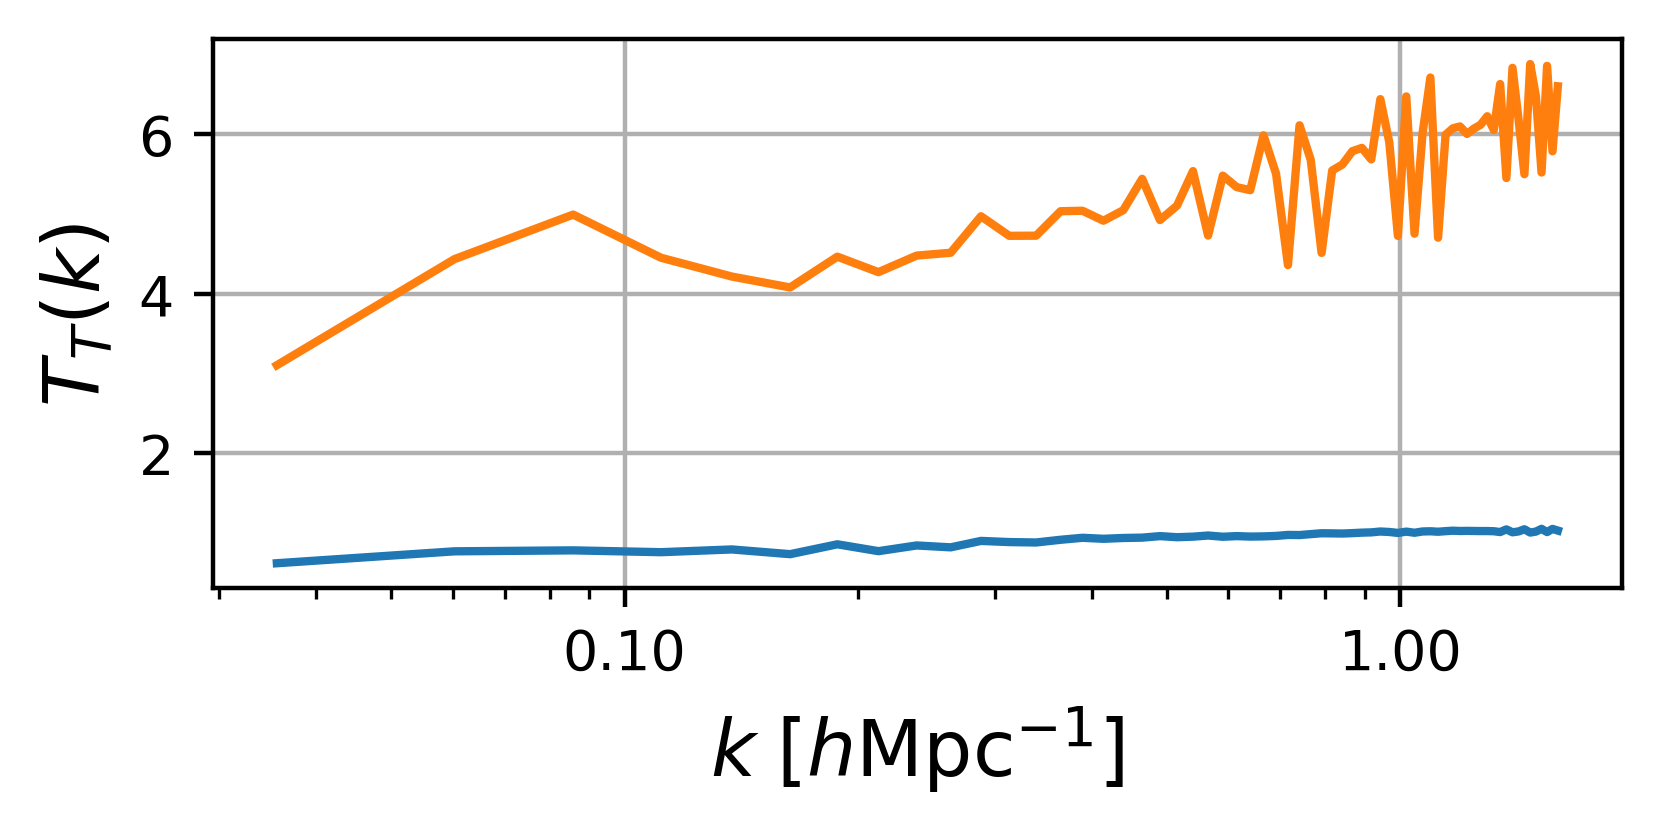

In [59]:
fig = plt.figure(figsize=(10, 4),dpi=200)
gs = GridSpec(nrows=2, ncols=2)

############Transfer Function############
ax0 = fig.add_subplot(gs[0, 1])
ax0.plot(Pk_GADGET['k'], T_GADGET_COLA,label='r COLA')
ax0.plot(Pk_GADGET['k'], T_GADGET_GENET,label='r GENET')

ax0.set_xlabel(r"$k \;[h \mathrm{Mpc}^{-1}]$",size=14)
ax0.set_xscale('log')
ax0.set_ylabel('$T_T(k)$',size=14)
ax0.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax0.grid()

/cfs/home/ludo4644/.local-co/envs/BORG/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/cfs/home/ludo4644/.local-co/envs/BORG/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/cfs/home/ludo4644/.local-co/envs/BORG/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/cfs/home/ludo4644/.local-co/envs/BORG/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


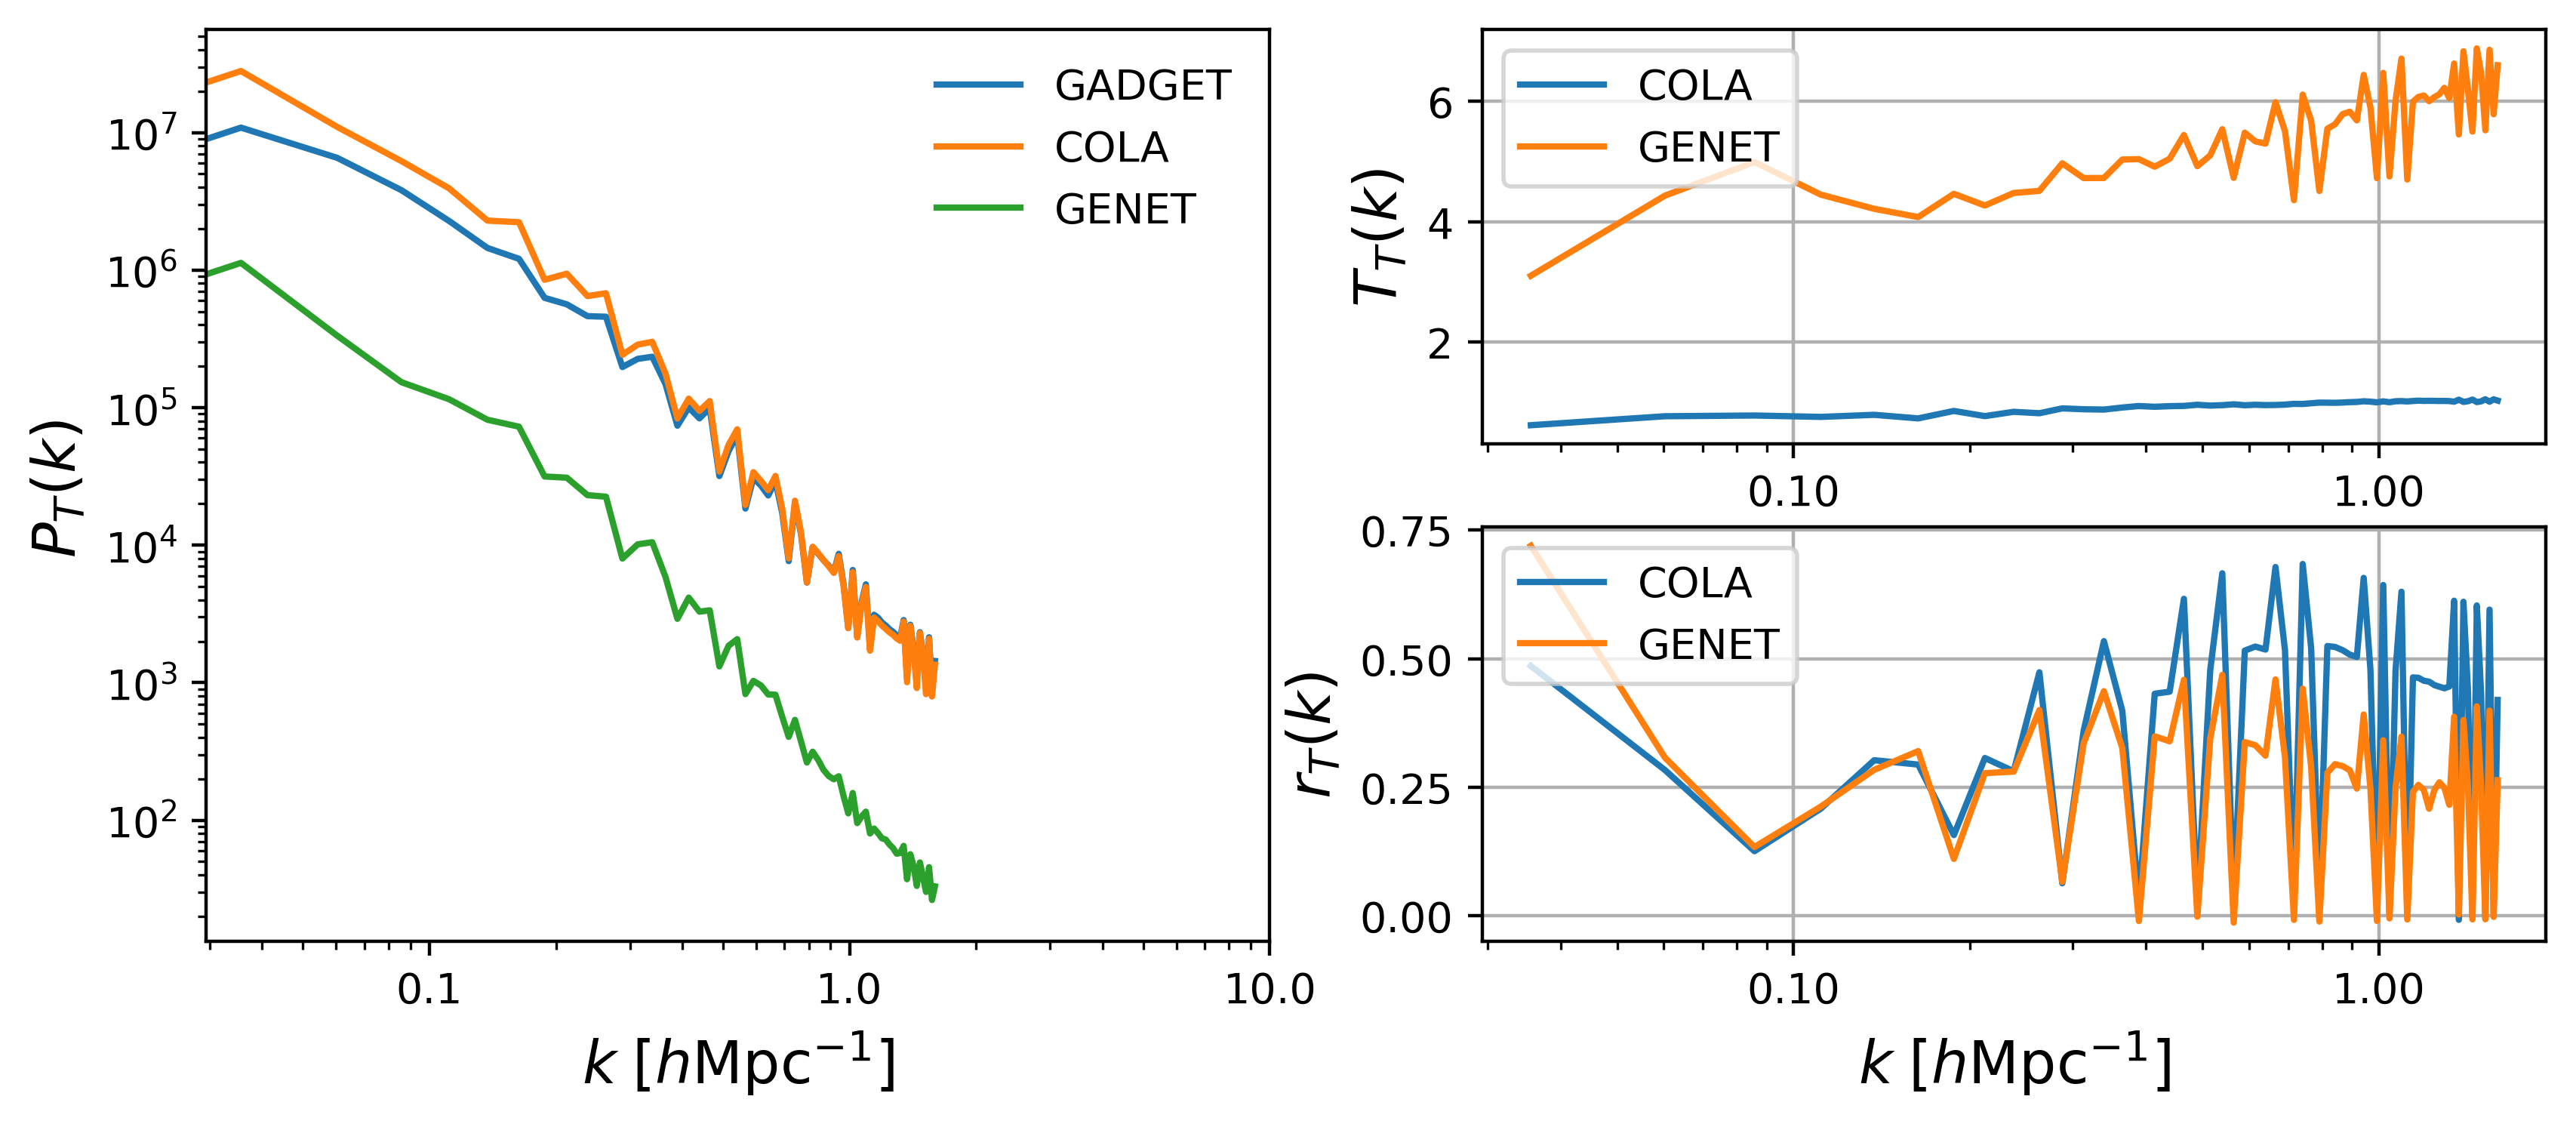

In [60]:
fig = plt.figure(figsize=(10, 4),dpi=200)
gs = GridSpec(nrows=2, ncols=2)

############Transfer Function############
ax0 = fig.add_subplot(gs[0, 1])
ax0.plot(Pk_GADGET['k'], T_GADGET_COLA,label='COLA')
ax0.plot(Pk_GADGET['k'], T_GADGET_GENET,label='GENET')

ax0.set_xlabel(r"$k \;[h \mathrm{Mpc}^{-1}]$",size=14)
ax0.set_xscale('log')
ax0.set_ylabel('$T_T(k)$',size=14)
ax0.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax0.legend()
ax0.grid()

############Cross Correlaiton Function############
ax1 = fig.add_subplot(gs[1, 1])
ax1.plot(Pk_GADGET['k'], r_GADGET_COLA,label='COLA')
ax1.plot(Pk_GADGET['k'], r_GADGET_GENET,label='GENET')

ax1.set_ylabel('$r_T(k)$',size=14)
ax1.set_xlabel(r"$k \;[h \mathrm{Mpc}^{-1}]$",size=14)
ax1.set_xscale('log')
ax1.grid()
ax1.legend()
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


############Power Spectra############
ax2 = fig.add_subplot(gs[:,0])
ax2.loglog(Pk_GADGET['k'], Pk_GADGET['power'].real, label='GADGET')
ax2.loglog(Pk_COLA  ['k'], Pk_COLA  ['power'].real, label='COLA')
ax2.loglog(Pk_GENET ['k'], Pk_GENET ['power'].real, label='GENET')


ax2.set_xlabel(r"$k\;[h \mathrm{Mpc}^{-1}]$",size=14)
ax2.set_ylabel(r"$P_{T}(k)$ ",size=14)
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.legend(frameon=False)
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_xticks([0.1, 1, 10])

plt.show()

# Check improvement

# INTO BORG

# Evaluation

# First run ML

%matplotlib inline 
%config InlineBackend.figure_format='retina'
%pylab inline

import h5py
import numpy as np
import pandas as pd
import struct

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, Model, Input
from tensorflow.keras.layers import*
import tensorflow.keras as keras

from nbodykit.lab import *
from nbodykit import setup_logging, style
from nbodykit.lab import ArrayMesh

# Dataloder

## Data Preparation 

###need to modify this for the training set
def random_select(DPF_COLA,DPF_GADGET,size=50): #for momentum
    #augmentation and such 
    """
    This function randomly select a subbox from a full volume simulation 
    return a cropped Displacement field with a size^3 volume
    """
    #random the rollling coordinate
    rnd=np.random.uniform(0,512-size,size=3).astype(int)
    DPF_COLA_cropped   = DPF_COLA  [rnd[0]:rnd[0]+size,rnd[1]:rnd[1]+size,rnd[2]:rnd[2]+size,:]
    DPF_GADGET_cropped = DPF_GADGET[rnd[0]:rnd[0]+size,rnd[1]:rnd[1]+size,rnd[2]:rnd[2]+size,:]
    
    return DPF_COLA_cropped , DPF_GADGET_cropped

def generator():
    """
    This function apply the data random_select (can be modified) 
    and batched the dataset on the fily
    """
    
    na=np.newaxis
    for i in range (128):

        # DPF_COLA,DPF_GADGET = padding(DPF_COLA,DPF_GADGET)
        
        DPF_COLA_cropped , DPF_GADGET_cropped = random_select(DPF_COLA,DPF_GADGET,size=32) #
        #yield (DM_cropped[:,:,:,na],fields_cropped)
        yield (DPF_COLA_cropped , DPF_GADGET_cropped)
        
dataset = tf.data.Dataset.from_generator(generator, (tf.float32, tf.float32))
dataset = dataset.cache().batch(64)
width, height, depth = 32, 32, 32

#sanity check
for i in dataset:
    print(i[0].shape)
    print(i[1].shape)

# Architecture

## U-net 3D

#this one bottleneck down to 8^3
def U_net_3d_1(width, height, depth,lr=0.001,input_ch=1):
    tf.keras.backend.clear_session()
    width, height, depth = 32, 32, 32
    
    in1 = keras.Input((width, height, depth, input_ch))

    conv1 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(in1)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling3D((2, 2, 2))(conv1)

    conv2 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling3D((2, 2, 2))(conv2)

    conv3 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(conv3)

    ########################################################
    up1 = concatenate([UpSampling3D((2, 2, 2))(conv3), conv2], axis=-1)
    conv4 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(up1)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

    up2 = concatenate([UpSampling3D((2, 2, 2))(conv4), conv1], axis=-1)
    conv6 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    ########################################################

    model = Model(inputs=[in1], outputs=[conv6],name='U-net3D')
    model.summary()
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

#this one bottleneck down to 4^3
def U_net_3d_2(width, height, depth,lr=0.001,input_ch=1):
    tf.keras.backend.clear_session()

    input_ch = 3
    in1 = keras.Input((width, height, depth, input_ch))

    conv1 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(in1)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling3D((2, 2, 2))(conv1)

    conv2 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling3D((2, 2, 2))(conv2)

    conv3 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = MaxPooling3D((2, 2, 2))(conv3)

    conv4 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

    ########################################################
    up1 = concatenate([UpSampling3D((2, 2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(up1)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(conv5)

    up2 = concatenate([UpSampling3D((2, 2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    #conv6 = Dropout(0.2)(conv6)
    conv6 = Conv3D(filters=16, kernel_size=2, activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    up3 = concatenate([UpSampling3D((2, 2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv3D(filters=16, kernel_size=(2, 2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(up3)
    #conv7 = Dropout(0.2)(conv7)
    conv7 = Conv3D(filters=16, kernel_size=(2, 2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    conv7 = Conv3D(filters=1, kernel_size=(2,2,2), kernel_initializer='he_normal', padding='same')(conv7)
    ########################################################
    
    model = Model(inputs=[in1], outputs=[conv7],name='U-net3D')
    model.summary()

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

# Training

%%time
#width, height, depth = 81, 81, 81
unet3d  = U_net_3d_2(width,height,depth,lr=0.002,input_ch=3)
#unet3d.load_weights('model_Unet.h5') 

run   = unet3d.fit(dataset, epochs=100)#,batch_size=32)#,steps_per_epoch=10)

plt.semilogy(run.history['loss'],label='loss')
plt.semilogy(run.history['mean_squared_error'],label='mse')
plt.legend()

unet3d.save_weights('model_UNET4BORG.h5') 

# Evaluation

def data_select(input_DPF,output_DPF,index,size=50): #for momentum

    i=index[0]
    j=index[1]
    k=index[2]
    
    input_DPF_cropped   = input_DPF  [(i*32):(i*32)+32 , (j*32):(j*32)+32 , (k*32):(k*32)+32]
    output_DPF_cropped  = output_DPF [(i*32):(i*32)+32 , (j*32):(j*32)+32 , (k*32):(k*32)+32]

    return input_DPF_cropped ,output_DPF_cropped

DPF_pred = np.zeros((32*16,32*16,32*16,3))
DPF_true = np.zeros((32*16,32*16,32*16,3))

for k in range(16):
    print(k)
    for j in range(16):
        for i in range(16):
            
            test_DPF, true_DPF = data_select(DPF_COLA,DPF_GADGET,[i,j,k],size=32)
            
            output_i = unet3d.predict(tf.expand_dims(test_DPF,axis=0))
            
            DPF_true[(32*i):(32*i)+32,(32*j):(32*j)+32,(32*k):(32*k)+32] = true_DPF
            DPF_pred[(32*i):(32*i)+32,(32*j):(32*j)+32,(32*k):(32*k)+32] = output_i
            
#f = h5py.File('predicted_DPF.h5', 'w')
#f.create_dataset("True", ((768,768,768)), dtype='f8',data=10**temp_true_roll) #'f8' for a double presicion
#f.create_dataset("Pred", ((768,768,768)), dtype='f8',data=10**temp_pred_roll) 
#f.close()

def dens_from_disp(disp,lagpos,L=1000,sub=True):
    pos = disp + lagpos
    pos[pos>L] -= L
    pos[pos<0] += L
    if sub:
        pos = pos[:,:128,:128,:128]
    
    return disp2dens(pos, L, N=np.shape(pos)[-1])

def disp2dens(pos, L, N, ngrid_pl=512):
    
    pos = pos.reshape(3,N**3,order='F')
    x,y,z = pos[0],pos[1],pos[2]

    return density(x,y,z, L, ngrid_pl)